# 프로젝트: 폐렴 진단기 성능개선

### Step 1. 실험환경 set_up하기

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

1 Physical GPUs, 1 Logical GPUs


변수 생성하기

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 32

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 50

print(ROOT_PATH)

/home/aiffel/aiffel


### Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train set 과 validation set 재분류 하기

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1059
Pneumonia images count in training set: 3126


In [6]:
# CNN 모델에서는 데이터가 균등할수록 training을 잘합니다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [9]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [11]:
#이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.

In [12]:
#이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.

In [13]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [14]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다. 
# num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해줍니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for image, label in train_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True


In [16]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [17]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step 3. 데이터 시각화하기

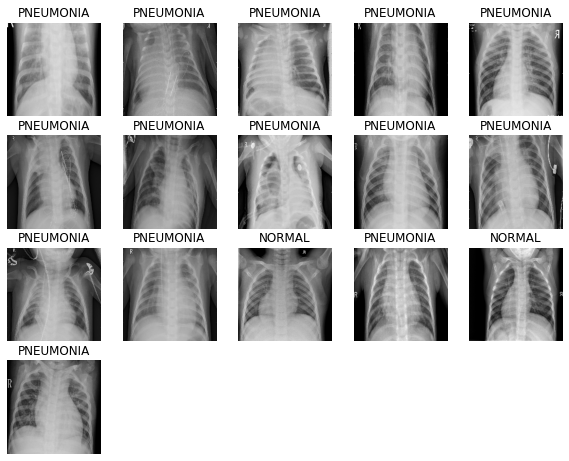

In [18]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. CNN모델링하기

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.4),
        dense_block(128, 0.2),
        dense_block(64, 0.1),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.98
Weight for class 1: 0.67


### Step 6. 모델 훈련

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCHS, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             
                             monitor='val_loss',   
                             verbose=1,            
                             save_best_only=True,  
                             mode='auto'
                            )

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=5)

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint, earlystopping, reduceLR],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
130/130 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.8721 - precision: 0.9718 - recall: 0.8537
Epoch 00001: val_loss improved from inf to 0.64393, saving model to checkpoint-epoch-50-batch-32-trial-001.h5
130/130 [==============================] - 20s 158ms/step - loss: 0.2887 - accuracy: 0.8721 - precision: 0.9718 - recall: 0.8537 - val_loss: 0.6439 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/50
130/130 [==============================] - ETA: 0s - loss: 0.1713 - accuracy: 0.9329 - precision: 0.9799 - recall: 0.9291
Epoch 00002: val_loss did not improve from 0.64393
130/130 [==============================] - 20s 155ms/step - loss: 0.1713 - accuracy: 0.9329 - precision: 0.9799 - recall: 0.9291 - val_loss: 0.8210 - val_accuracy: 0.7227 - val_precision: 0.7227 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/50
130/130 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9462 - precision: 0.9829

Epoch 20/50
130/130 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9882 - precision: 0.9961 - recall: 0.9880- ETA: 4s - loss: 0.0328 - accur
Epoch 00020: val_loss did not improve from 0.04390
130/130 [==============================] - 20s 155ms/step - loss: 0.0352 - accuracy: 0.9882 - precision: 0.9961 - recall: 0.9880 - val_loss: 0.0712 - val_accuracy: 0.9707 - val_precision: 0.9944 - val_recall: 0.9648 - lr: 3.1250e-05
Epoch 21/50
130/130 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9846 - precision: 0.9971 - recall: 0.9823
Epoch 00021: val_loss did not improve from 0.04390
130/130 [==============================] - 17s 134ms/step - loss: 0.0406 - accuracy: 0.9846 - precision: 0.9971 - recall: 0.9823 - val_loss: 0.0468 - val_accuracy: 0.9824 - val_precision: 0.9931 - val_recall: 0.9824 - lr: 3.1250e-05
Epoch 22/50
130/130 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9885 - precision: 0.9968 - recall: 0.987

### Step 7. 결과 확인 및 시각화

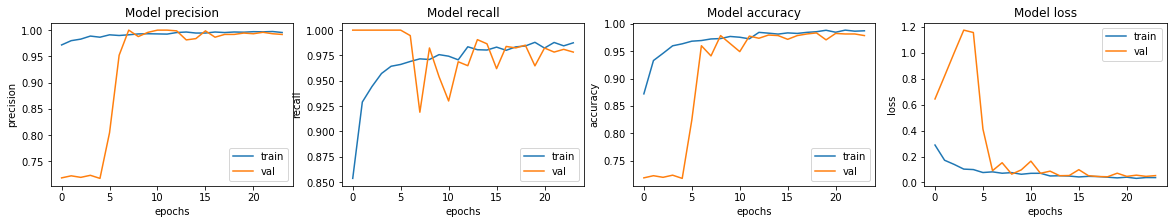

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 2s 115ms/step - loss: 0.8685 - accuracy: 0.7644 - precision: 0.7280 - recall: 0.9949


# 결과 및 분석

폐렴 의료영상을 CNN구조를 통해 분석해보는 시간을 가졌다.  

결과적으로 CNN모델에서 Batch nomalization, drop out을 둘 다 사용하였을때 정확도가 76.4% 로 가장 높게 나왔다.  

이 두가지 기법을 다 사용하는 평범한 방법이 아닌지라 한가지 기법만을 사용한채로 학습을 진행하였지만 두가지 기법을 한번에 사용하였을때 가장 성능이 좋게나왔다. 의료영상분석에 국한되여 성능을 끌어올릴때 사용하는 방법이라고 한다.  